In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Pour la visualisation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    average_precision_score, precision_recall_curve, f1_score
)
from sklearn.utils import shuffle

# Imports pour le multiprocessing
import multiprocessing
from tqdm import tqdm

# --- NOTRE NOUVEL IMPORT DE FEATURES ---
from src.features_periodogram import generate_periodogram_features

print("Bibliothèques importées.")
# Si seaborn n'est pas installé : !pip install seaborn

Bibliothèques importées.


In [3]:
print("Chargement et mélange des données brutes...")
train_df = pd.read_csv('../data/raw/train.csv')

X_raw = train_df.drop('LABEL', axis=1).values
y = train_df['LABEL'].values - 1  # (0, 1)

X_raw_shuffled, y_shuffled = shuffle(X_raw, y, random_state=42)

print(f"Forme de X_raw_shuffled : {X_raw_shuffled.shape}")
print(f"Forme de y_shuffled : {y_shuffled.shape}")

Chargement et mélange des données brutes...
Forme de X_raw_shuffled : (5087, 3197)
Forme de y_shuffled : (5087,)


In [4]:
# Cellule 3 : Génération des Features Statistiques
# ------------------------------------------------
X_data_to_process = X_raw_shuffled

print(f"Démarrage de la génération des features (4 par étoile)...")

N_CORES = multiprocessing.cpu_count() - 1
if N_CORES < 1: N_CORES = 1
print(f"Utilisation de {N_CORES} cœurs CPU...")

with multiprocessing.Pool(processes=N_CORES) as pool:
    # pool.map fonctionne car notre fonction n'a qu'un seul argument requis
    X_features_list = list(tqdm(pool.map(generate_periodogram_features, X_data_to_process), total=len(X_data_to_process)))

# Convertir la liste de résultats en array numpy
X_features = np.array(X_features_list)
y = y_shuffled

print("Génération des features terminée !")
print(f"Forme de X_features : {X_features.shape}")

Démarrage de la génération des features (4 par étoile)...
Utilisation de 7 cœurs CPU...


100%|██████████| 5087/5087 [00:00<00:00, 1976326.83it/s]

Génération des features terminée !
Forme de X_features : (5087, 4)


In [5]:
# Cellule 4 : Création du DataFrame
# -----------------------------------
# Créons un DataFrame pour analyser nos nouvelles features

feature_names = ['max_power', 'mean_power', 'std_power', 'peak_significance']
df = pd.DataFrame(X_features, columns=feature_names)
df['label'] = y

print("Aperçu du DataFrame de features :")
print(df.head())

print("\nDescription statistique (Toutes les étoiles) :")
print(df.describe())

print("\nDescription statistique (Seulement les Planètes) :")
print(df[df['label'] == 1].describe())

Aperçu du DataFrame de features :
   max_power  mean_power  std_power  peak_significance  label
0   0.039448    0.000625   0.001624          23.912480      0
1   0.068616    0.000619   0.003335          20.386495      0
2   0.483231    0.000612   0.010441          46.222237      1
3   0.018069    0.000628   0.000744          23.448714      0
4   0.525066    0.000629   0.002945         178.059955      0

Description statistique (Toutes les étoiles) :
         max_power   mean_power    std_power  peak_significance        label
count  5087.000000  5087.000000  5087.000000        5087.000000  5087.000000
mean      0.837425     0.000633     0.004533         137.694956     0.007273
std       1.943180     0.000027     0.005105         136.497548     0.084982
min       0.001608     0.000600     0.000093           3.181751     0.000000
25%       0.080177     0.000623     0.001517          35.709637     0.000000
50%       0.223961     0.000628     0.002686          64.117129     0.000000
75%    

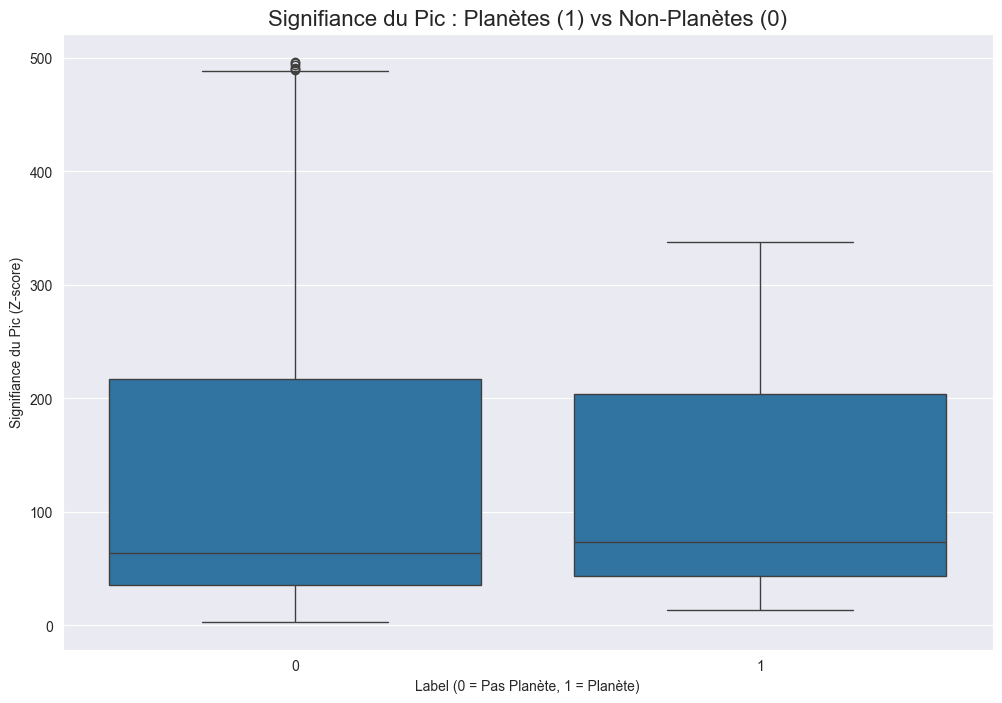

In [6]:
# Cellule 5 : Visualisation des Features
# --------------------------------------
# C'est le test de vérité.
# La feature 'peak_significance' est-elle différente pour
# les planètes (1) et les non-planètes (0) ?

plt.figure(figsize=(12, 8))
sns.boxplot(x='label', y='peak_significance', data=df)
plt.title('Signifiance du Pic : Planètes (1) vs Non-Planètes (0)', fontsize=16)
plt.xlabel("Label (0 = Pas Planète, 1 = Planète)")
plt.ylabel("Signifiance du Pic (Z-score)")
plt.show()

# (Hypothèse : La boîte "1" devrait être BEAUCOUP plus haute que la "0")

In [7]:
# Cellule 6 : Train/Test Split
# -----------------------------
print("Division des données (features)...")

X_train, X_test, y_train, y_test = train_test_split(
    X_features, # <-- Nos 4 features
    y,          # <-- Nos labels
    test_size=0.2,
    random_state=42,
    stratify=y  # Indispensable
)

print(f"Forme X_train : {X_train.shape}")
print(f"Forme X_test : {X_test.shape}")

Division des données (features)...
Forme X_train : (4069, 4)
Forme X_test : (1018, 4)


In [8]:
# Cellule 7 : Entraînement du Modèle Statistique (v23)
# ----------------------------------------------------
print("Entraînement du Random Forest Classifier...")

# On utilise class_weight='balanced' car Random Forest
# le gère très bien.
rf_model = RandomForestClassifier(
    n_estimators=100,     # 100 arbres
    class_weight='balanced',
    random_state=42,
    n_jobs=-1             # Utiliser tous les coeurs
)

rf_model.fit(X_train, y_train)

print("Entraînement terminé.")

Entraînement du Random Forest Classifier...
Entraînement terminé.


In [9]:
# Cellule 8 : Évaluation Finale (v23)
# -----------------------------------
print("Évaluation du modèle Random Forest...")

y_pred_class = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1] # Probabilité de la classe "1"

print("\n" + "="*40)
print("ÉVALUATION FINALE (Random Forest)")
print("="*40)

print("\n--- Rapport de Classification ---")
print(classification_report(y_test, y_pred_class, target_names=['Pas Planète', 'Planète']))

print("\n--- Matrice de Confusion ---")
print(confusion_matrix(y_test, y_pred_class))

# Le score PR-AUC (notre métrique clé)
pr_auc_score = average_precision_score(y_test, y_pred_proba)
print(f"\nScore PR-AUC global (Average Precision) : {pr_auc_score:.4f}")

Évaluation du modèle Random Forest...

ÉVALUATION FINALE (Random Forest)

--- Rapport de Classification ---
              precision    recall  f1-score   support

 Pas Planète       0.99      1.00      1.00      1011
     Planète       0.00      0.00      0.00         7

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.99      0.99      0.99      1018


--- Matrice de Confusion ---
[[1011    0]
 [   7    0]]

Score PR-AUC global (Average Precision) : 0.0098


C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(